# Finding the Groove: Uncovering Business Insights of Chinhook Music Store

In this project, we'll be working with the [Chinook](https://github.com/lerocha/chinook-database) database. The Chinook database contains information about a fictional digital music shop - kind of like a mini-iTunes store.

The Chinook database contains information about the artists, songs, and albums from the music shop, as well as information on the shop's employees, customers, and the customers purchases. This information is contained in eleven tables.

The main objectives of this project are to answer the following business questions for Chinook:
1. Identify the top three albums from a new record label to add to the store.
2. Analyze the sales performance of sales support agents to identify the best performer.
3. Analyze sales by country to determine average sales and order value.
4. Determine if more revenue is generated from individual track purchases or album purchases.

In [1]:
%%capture
%load_ext sql
%sql sqlite:///chinook.db

Let's start by getting familiar with the data we're going to be working with. We will explore the dataset by checking the number of tables in the database.

In [2]:
%%sql
SELECT
    name,
    type
FROM sqlite_master
WHERE type IN ("table","view");

 * sqlite:///chinook.db
Done.


name,type
album,table
artist,table
customer,table
employee,table
genre,table
invoice,table
invoice_line,table
media_type,table
playlist,table
playlist_track,table


There are **11 tables** in the database. Each containing information about various items. We can refer to the schema diagram below to see how each table is related to one another.

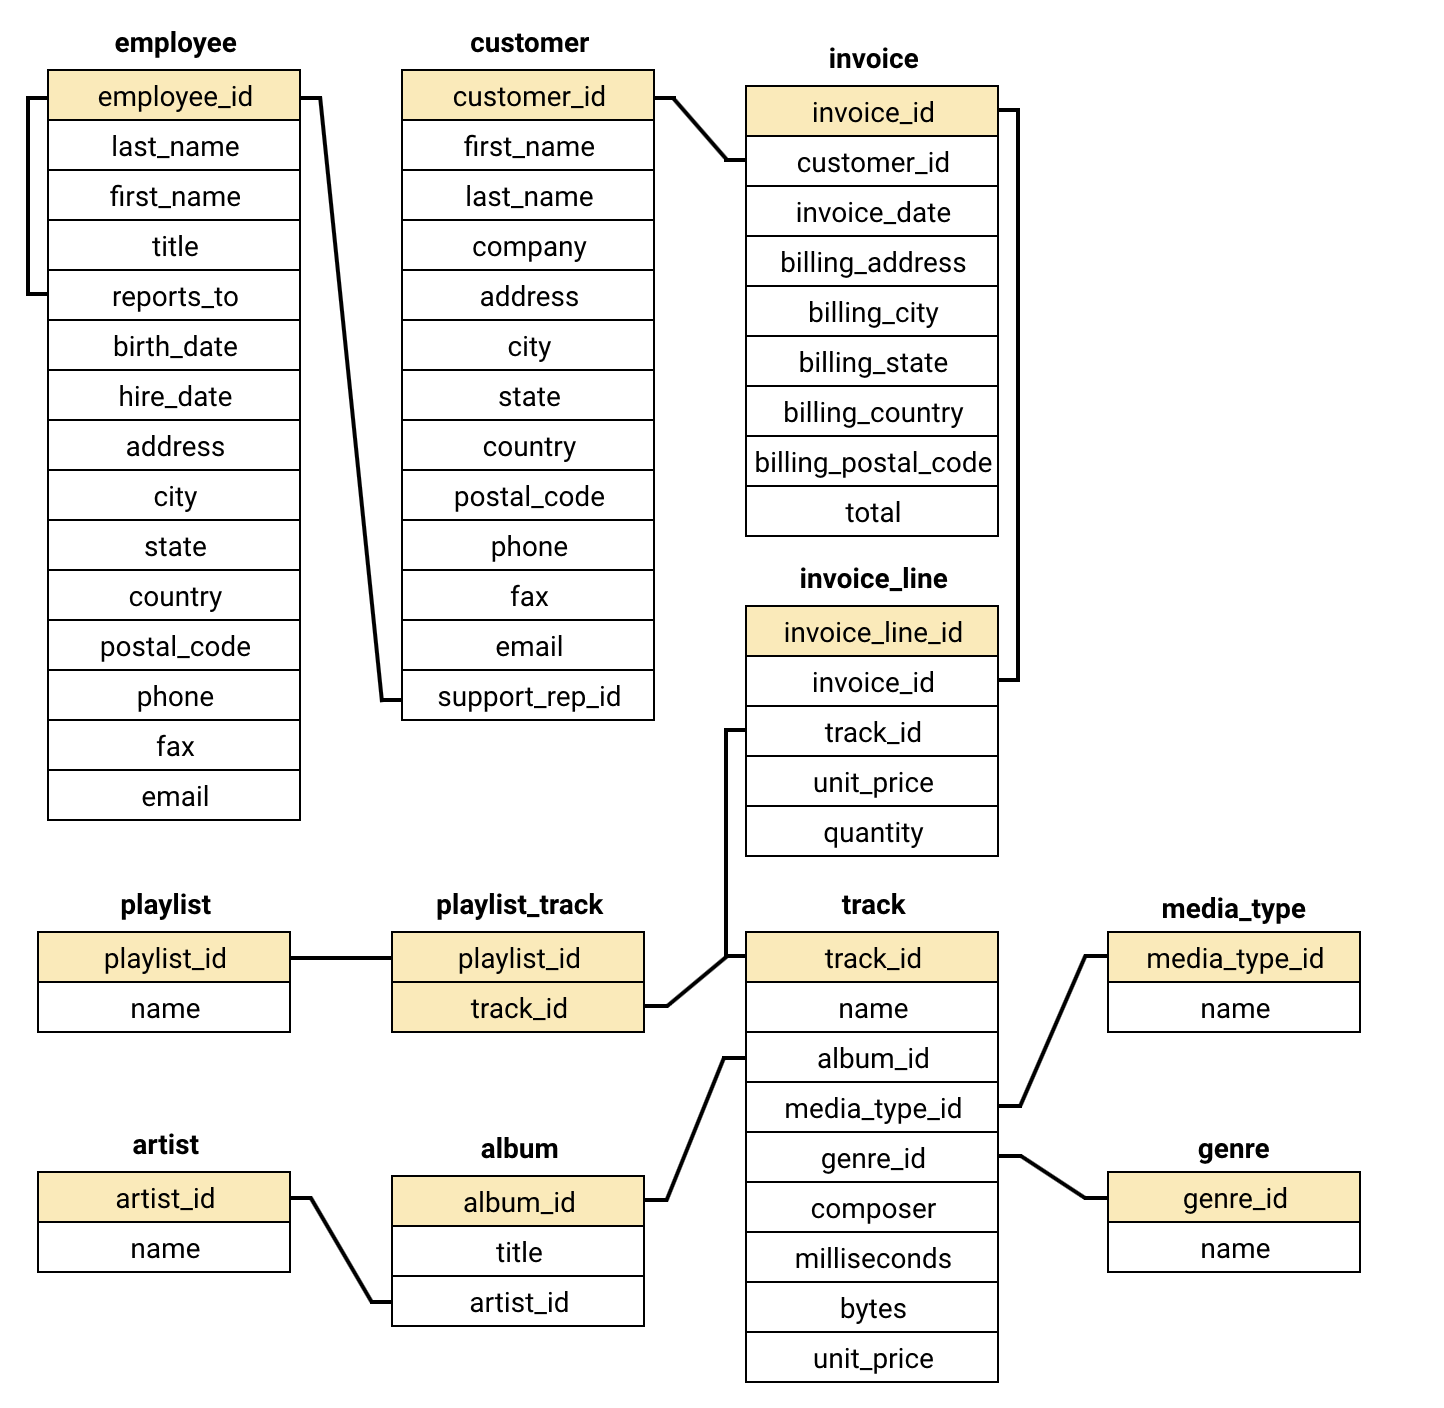

Now that we are familiar with the tables in the database and how they are related, let's start anwering our business questions, one by one.

# Selecting Albums to Purchase

Now, we will answer the first question of our analysis. The Chinook record store has just signed a deal with a new record label, and we need to find the first three albums that will be added to the store, from a list of four. 

All four albums are by artists that don't have any tracks in the store right now - we have the artist names, and the genre of music they produce:

| Artist Name      | Genre    |
|------------------|----------|
| Regal            | Hip-Hop  |
| Red Tone         | Punk     |
| Meteor and the Girls | Pop  |
| Slim Jim Bites   | Blues    |


The record label specializes in artists from the USA, and they have given Chinook some money to advertise the new albums in the USA, **so we're interested in finding out which genres sell the best in the USA.**

So, we will write a query to find out which genres sell the most tracks in the USA.

In [3]:
%%sql

WITH top_tracks_USA as 
    (
    SELECT
        t.genre_id as genre_id,
        count(*) as no_of_tracks_sold,
        ROUND(CAST(COUNT(t.track_id) AS FLOAT) / (SELECT COUNT(*) FROM invoice_line il
                                                 JOIN invoice i ON il.invoice_id = i.invoice_id
                                                 WHERE i.billing_country = 'USA') * 100, 2) AS percentage
    FROM invoice i
    INNER JOIN invoice_line il ON i.invoice_id = il.invoice_id
    INNER JOIN track t ON t.track_id = il.track_id
    WHERE i.billing_country = 'USA'
    GROUP BY genre_id
    )
    
SELECT
    g.name as genre,
    t.no_of_tracks_sold,
    t.percentage
FROM genre g
INNER JOIN top_tracks_USA t ON t.genre_id = g.genre_id
GROUP BY g.name
ORDER BY 2 DESC
LIMIT 10;

 * sqlite:///chinook.db
Done.


genre,no_of_tracks_sold,percentage
Rock,561,53.38
Alternative & Punk,130,12.37
Metal,124,11.8
R&B/Soul,53,5.04
Blues,36,3.43
Alternative,35,3.33
Pop,22,2.09
Latin,22,2.09
Hip Hop/Rap,20,1.9
Jazz,14,1.33


We have obtained the top selling genres of the USA. The top 3 are **Rock (53.38%), Alternative & Punk (12.37%) and Metal (11.8%).**

But, as mentioned earlier, we need to select only 3 albums out of 4 to be added to the store, based on the genres that are already in the top 10 list. According to the percentages obtained above, the selected artists will be:

* Red Tone (Punk)
* Slim Jim Bites (Blues)
* Meteor and the Girls (Pop)

# Analyzing Employee Sales Performance

Each customer in the Chinook store gets assigned to a sales support agent within the company when they make a first purchase. We have been asked to analyze the purchases of customers belonging to each employee to see if any sales support agent is performing either better or worse than the others. 

In [4]:
%%sql

WITH total_sales as
    (
    SELECT
        c.support_rep_id as emp_id,
        e.first_name || ' ' || e.last_name as emp_name,
        COUNT(c.customer_id) as total_customers_alloted,
        ROUND(SUM(i.total), 2) as total_sales_usd
    FROM customer c
    INNER JOIN invoice i ON c.customer_id = i.customer_id
    INNER JOIN employee e ON c.support_rep_id = e.employee_id
    GROUP BY emp_id
    )

SELECT *
FROM total_sales
WHERE total_sales_usd > (SELECT sum(total) / count(*)
                         FROM invoice)

 * sqlite:///chinook.db
Done.


emp_id,emp_name,total_customers_alloted,total_sales_usd
3,Jane Peacock,212,1731.51
4,Margaret Park,214,1584.0
5,Steve Johnson,188,1393.92


In terms of customer acquisition i.e., making the first purchases to a new customer, **Margaret Park has performed well with 214 customers.**

In terms of total sales made, **Jane Peacock has made the highest sales with 1731.51 USD.**

An interesting observation is that having more customers assigned to an employee does not necessarily mean that they have made more sales. This is because each customer's buying quantity may differ when they are making their first purchase.

# Analyzing Sales by Country

Now that we have analyzed sales by each employee lets analyze the sales data for customers from each different country. 

Since, there will be number of countries with only one customer, we'll group these customers as "Other".

In [5]:
%%sql
WITH country_or_other AS
    (
     SELECT
       CASE
           WHEN (
                 SELECT count(*)
                 FROM customer
                 where country = c.country
                ) = 1 THEN "Other"
           ELSE c.country
       END AS country,
       c.customer_id,
       il.*
     FROM invoice_line il
     INNER JOIN invoice i ON i.invoice_id = il.invoice_id
     INNER JOIN customer c ON c.customer_id = i.customer_id
    )

SELECT
    country,
    customers,
    total_sales,
    average_order,
    customer_lifetime_value
FROM
    (
    SELECT
        country,
        count(distinct customer_id) customers,
        SUM(unit_price) total_sales,
        SUM(unit_price) / count(distinct customer_id) customer_lifetime_value,
        SUM(unit_price) / count(distinct invoice_id) average_order,
        CASE
            WHEN country = "Other" THEN 1
            ELSE 0
        END AS sort
    FROM country_or_other
    GROUP BY country
    ORDER BY sort ASC, total_sales DESC
    );
    

 * sqlite:///chinook.db
Done.


country,customers,total_sales,average_order,customer_lifetime_value
USA,13,1040.490000000008,7.942671755725252,80.03769230769292
Canada,8,535.5900000000034,7.047236842105309,66.94875000000043
Brazil,5,427.68000000000245,7.011147540983647,85.53600000000048
France,5,389.0700000000021,7.781400000000042,77.81400000000042
Germany,4,334.6200000000016,8.161463414634186,83.6550000000004
Czech Republic,2,273.24000000000103,9.108000000000034,136.62000000000052
United Kingdom,3,245.52000000000078,8.768571428571457,81.84000000000026
Portugal,2,185.13000000000022,6.3837931034482835,92.56500000000011
India,2,183.1500000000002,8.72142857142858,91.5750000000001
Other,15,1094.9400000000085,7.448571428571486,72.99600000000056


The analysis shows that the USA has the highest total sales, total customers, and average sales per customer, indicating that it is an essential market for the company. Brazil and Canada also show strong sales performance.

# Albums vs Individual Tracks

The Chinhook store allows customers to make purchase in one of the two ways:
* Purchase a whole album.
* Purchase a collection of one or more individual tracks.

The store does not let customers purchase a whole album, and then add individual tracks to that same purchase (unless they do that by choosing each track manually). When customers purchase albums they are charged the same price as if they had purchased each of those tracks separately.

Management are currently considering changing their purchasing strategy to save money. The strategy they are considering is to purchase only the most popular tracks from each album from record companies, instead of purchasing every track from an album.

We need to find out **what percentage of purchases are individual tracks vs whole albums**, so that management can use this data to understand the effect this decision might have on overall revenue.

In [6]:
%%sql

WITH invoice_first_track AS
   (
    SELECT
        il.invoice_id invoice_id,
        MIN(il.track_id) first_track_id
    FROM invoice_line il
    GROUP BY 1
   )

SELECT
    CASE
        WHEN
            (
            SELECT t.track_id FROM track t
            WHERE t.album_id = 
                (SELECT t2.album_id FROM track t2
                 WHERE t2.track_id = ift.first_track_id)
                 
            EXCEPT
            
            SELECT il2.track_id FROM invoice_line il2
            WHERE il2.invoice_id = ift.invoice_id
            ) IS NULL
            
            AND
            
            (
            SELECT il2.track_id FROM invoice_line il2
            WHERE il2.invoice_id = ift.invoice_id
            
            EXCEPT
            
            SELECT t.track_id FROM track t
            WHERE t.album_id = 
                (SELECT t2.album_id FROM track t2
                 WHERE t2.track_id = ift.first_track_id)
            ) IS NULL
        THEN 'Album'
        ELSE 'Individual Tracks'
    END AS 'Purchase Type',
    COUNT(DISTINCT ift.invoice_id) AS 'Number of Invoices',
    ROUND(CAST(COUNT(DISTINCT ift.invoice_id) AS FLOAT) / (SELECT COUNT(*) FROM invoice)*100, 2) AS 'Percentage of Invoices'
FROM invoice_first_track ift
GROUP BY 1;




 * sqlite:///chinook.db
Done.


Purchase Type,Number of Invoices,Percentage of Invoices
Album,114,18.57
Individual Tracks,500,81.43


The Chinook store sells both individual tracks and albums, with about **81.43% of their sales coming from individual tracks** and the remaining **18.57% coming from album purchases.**

However, since the majority of the sales come from individual tracks, it might be more profitable for the store to switch to purchasing only the most popular tracks from each album instead of buying full albums from record companies. This could help the store save money on less popular tracks and potentially increase overall revenue.

# Findings

The findings of the project provide valuable insights into the business operations of the Chinook Music Store. The company can use this information to make strategic decisions that could positively impact their revenue.

* The top selling genres in the USA were Rock (53.38%), Alternative & Punk (12.37%) and Metal (11.8%).
* An employee named Margaret Park made the most number of first purchases and a different employee - Jane Peacock - made the highest sales of 1731.51 USD. Having more customers assigned to an employee does not necessarily mean that they have made more sales.
* USA has the highest total sales, total customers, and average sales per customer, indicating that it is an essential market for the company.
* The company made 81.43% of their sales by selling individual tracks, indicating that customers are not interested in purchasing full albums.